In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Input, InputLayer, Dropout, Dense, Flatten, Embedding, Add, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop

from sklearn.metrics import precision_recall_fscore_support

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [48]:
df = pd.read_csv('./data/kokil dec 6 reprepare/conf_pc_worker_sem.csv')
df = df.dropna()

In [49]:
# Throughput (Average)
df_throughput = df[['Throughput.1', 'Throughput.2', 'Throughput.3', 'Throughput.4', 'Throughput.5']].copy()
df_throughput['avg_throughput'] = df_throughput.mean(axis=1)
df_throughput['avg_throughput'] = df_throughput['avg_throughput'] / df_throughput['avg_throughput'].max()

# WorkTime
df_worktime = df[['WorkTime.1', 'WorkTime.2', 'WorkTime.3', 'WorkTime.4', 'WorkTime.5']].copy()
df_worktime['avg_worktime'] = df_worktime.mean(axis=1)
df_worktime['avg_worktime'] = df_worktime['avg_worktime'] / df_worktime['avg_worktime'].max()

In [73]:
df_throughput.head()

,Throughput.1,Throughput.2,Throughput.3,Throughput.4,Throughput.5,avg_throughput
5,390,2331,193,2139,162.0,0.373996
6,234,2134,2331,1022,1411.0,0.511474
7,521,2139,2660,1411,892.0,0.546687
8,2632,2415,1482,892,3747.0,0.800918
9,2905,95,528,892,300.0,0.338497


Plot old throughput (x-axis) vs new throughput (y-axis)


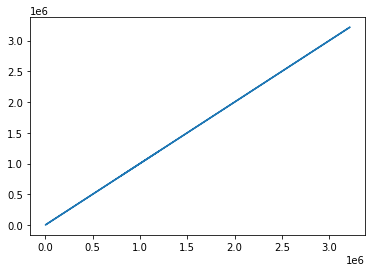

In [9]:
# Throughput weighted by variance 
df_throughput = df[['Throughput.1', 'Throughput.2', 'Throughput.3', 'Throughput.4', 'Throughput.5']].copy()
df_throughput['var_throughput'] = df_throughput.var(axis=1)
print("Plot old throughput (x-axis) vs new throughput (y-axis)")
plt.plot(df_throughput['var_throughput'], df_throughput['var_throughput'])
df_throughput['var_throughput'] = df_throughput['var_throughput'] / df_throughput['var_throughput'].max()

# WorkTime (weighted by variance)
df_worktime = df[['WorkTime.1', 'WorkTime.2', 'WorkTime.3', 'WorkTime.4', 'WorkTime.5']].copy()
df_worktime['var_worktime'] = df_worktime.var(axis=1)
df_worktime['var_worktime'] = df_worktime['var_worktime'] / df_worktime['var_worktime'].max()

Plot old throughput (x-axis) vs new throughput (y-axis)


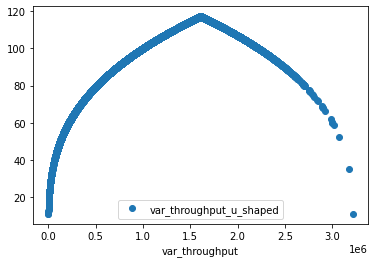

In [59]:
# Throughput (weighted by inverted V-shape variance)
df_throughput = df[['Throughput.1', 'Throughput.2', 'Throughput.3', 'Throughput.4', 'Throughput.5']].copy()
df_throughput['var_throughput'] = df_throughput.var(axis=1)
max_val = df_throughput['var_throughput'].max()
min_val = df_throughput['var_throughput'].min()
tp_mid = ((max_val - min_val) // 2) + min_val
tp_to_list = df_throughput['var_throughput'].tolist()

amount_of_curve = 3

u_shaped_variance = []
for each in tp_to_list:
    if each > tp_mid:
        u_shaped_variance.append((2*tp_mid - each)**(1/amount_of_curve))
    else:
        u_shaped_variance.append(each**(1/amount_of_curve))
        
df_throughput['var_throughput_u_shaped'] = u_shaped_variance
print("Plot old throughput (x-axis) vs new throughput (y-axis)")
df_throughput.plot(x='var_throughput', y='var_throughput_u_shaped', style='o')
df_throughput['var_throughput_u_shaped'] = df_throughput['var_throughput_u_shaped'] / df_throughput['var_throughput_u_shaped'].max()
df_throughput = df_throughput.assign(var_throughput=df_throughput['var_throughput_u_shaped'])


In [23]:
# PC Agreement (weighted by average)
df_agreement = df[['Answer.1gamemove.yes_pc_agree', 'Answer.2reasoning.yes_pc_agree', 'Answer.4shareinformation.yes_pc_agree', 'Answer.3rapport.yes_pc_agree']]
df_agreement['avg_agreement'] = df_agreement.mean(axis=1)
df_agreement['avg_agreement'] = df_agreement['avg_agreement'] / df_agreement['avg_agreement'].max()

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [50]:
# PC Agreement (weighted by variance)
df_agreement = df[['Answer.1gamemove.yes_pc_agree', 'Answer.2reasoning.yes_pc_agree', 'Answer.4shareinformation.yes_pc_agree', 'Answer.3rapport.yes_pc_agree']]
df_agreement['var_agreement'] = df_agreement.var(axis=1)
df_agreement['var_agreement'] = df_agreement['var_agreement'] / df_agreement['var_agreement'].max()

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [51]:
df = df.drop(columns=['Input.msg_id', 'HITId', 'Input.sentence_id', 'Input.convo_id', 'Input.train_test_val',
                     'Input.similar_text_id', 'Input.msg_id', 'Input.timestamp', 'Input.full_text',
                      'Input.speaker', 'Input.reply_to', 
                      'Input.game_score_delta', 'Input.game_score_receiver',
                      'Input.speaker_intention', 'Input.reciever_perception', 'Input.reciever',
                      'Input.absolute_message_index', 'Input.relative_message_index', 'Input.year',
                      'Input.game_score_speaker', 'Input.num_words', 'Input.num_characters', 
                      'Input.sno', 'Input.sno1',
                      'WorkTime.1', 'WorkTime.2', 'WorkTime.3', 'WorkTime.4', 'WorkTime.5',
                      'Throughput.1', 'Throughput.2', 'Throughput.3', 'Throughput.4', 'Throughput.5',
                      'Answer.1gamemove.yes', 'Answer.2reasoning.yes',
                      'Answer.3a_apologies.yes', 'Answer.3a_compliment.yes', 'Answer.3a_personalthoughts.yes',
                      'Answer.3a_reassurance.yes', 'Answer.3rapport.yes', 'Answer.4shareinformation.yes', 'count',
                      'Answer.1gamemove.yes_pc_agree', 'Answer.2reasoning.yes_pc_agree', 
                      'Answer.3a_apologies.yes_pc_agree', 'Answer.3a_compliment.yes_pc_agree',
                      'Answer.3a_personalthoughts.yes_pc_agree', 'Answer.3a_reassurance.yes_pc_agree',
                      'Answer.3rapport.yes_pc_agree', 'Answer.4shareinformation.yes_pc_agree', 
                      'message_id.x', 'message_id.y',
                      'Answer.3a_apologies.yes_label', 'Answer.3a_compliment.yes_label',
                      'Answer.3a_personalthoughts.yes_label', 'Answer.3a_reassurance.yes_label'
                     ])

In [52]:
indices = range(df.shape[0])

In [53]:
train, test, indices_train, indices_test = train_test_split(df, indices, test_size=0.2)

new_deception_train = train["Input.deception_quadrant"].copy()
new_deception_train['Input.deception_quadrant'] = train["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_train_deception = new_deception_train['Input.deception_quadrant'].tolist()
y_train_rapport = train['Answer.3rapport.yes_label'].tolist()
y_train_share_information = train['Answer.4shareinformation.yes_label'].tolist()
y_train_reasoning = train['Answer.2reasoning.yes_label'].tolist()
y_train_gamemove = train['Answer.1gamemove.yes_label'].tolist()

new_deception_test = test["Input.deception_quadrant"].copy()
new_deception_test['Input.deception_quadrant'] = test["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_test_deception = new_deception_test['Input.deception_quadrant'].tolist()
y_test_rapport = test['Answer.3rapport.yes_label'].tolist()
y_test_share_information = test['Answer.4shareinformation.yes_label'].tolist()
y_test_reasoning = test['Answer.2reasoning.yes_label'].tolist()
y_test_gamemove = test['Answer.1gamemove.yes_label'].tolist()

X_train = train.drop(columns=['Answer.1gamemove.yes_label', 'Answer.2reasoning.yes_label',
                              'Answer.3rapport.yes_label', 'Answer.4shareinformation.yes_label', 'Input.deception_quadrant'])

X_test = test.drop(columns=['Answer.1gamemove.yes_label', 'Answer.2reasoning.yes_label',
                              'Answer.3rapport.yes_label', 'Answer.4shareinformation.yes_label', 'Input.deception_quadrant'])

### Individual classifiers are Random Forests

In [54]:
# Game move classifier
clf_gamemove = RandomForestClassifier(max_depth=2, random_state=0)
clf_gamemove.fit(X_train, y_train_gamemove)
y_pred_gamemove = clf_gamemove.predict(X_train)
y_pred_test_gamemove = clf_gamemove.predict(X_test)
print(classification_report(y_pred_gamemove, y_train_gamemove))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.93      0.96      9092

    accuracy                           0.93      9092
   macro avg       0.50      0.47      0.48      9092
weighted avg       1.00      0.93      0.96      9092



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
# Rapport classifier
clf_rapport = RandomForestClassifier(max_depth=2, random_state=0)
clf_rapport.fit(X_train, y_train_rapport)
y_pred_rapport = clf_rapport.predict(X_train)
y_pred_test_rapport = clf_rapport.predict(X_test)
print(classification_report(y_pred_rapport, y_train_rapport))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.86      0.93      9092

    accuracy                           0.86      9092
   macro avg       0.50      0.43      0.46      9092
weighted avg       1.00      0.86      0.93      9092



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
# Share Information classifier
clf_shareinfo = RandomForestClassifier(max_depth=2, random_state=0)
clf_shareinfo.fit(X_train, y_train_share_information)
y_pred_shareinfo = clf_shareinfo.predict(X_train)
y_pred_test_shareinfo = clf_shareinfo.predict(X_test)
print(classification_report(y_pred_shareinfo, y_train_share_information))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.84      0.91      9092

    accuracy                           0.84      9092
   macro avg       0.50      0.42      0.46      9092
weighted avg       1.00      0.84      0.91      9092



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
# Reasoning classifier
clf_reasoning = RandomForestClassifier(max_depth=2, random_state=0)
clf_reasoning.fit(X_train, y_train_reasoning)
y_pred_reasoning = clf_reasoning.predict(X_train)
y_pred_test_reasoning = clf_reasoning.predict(X_test)
print(classification_report(y_pred_reasoning, y_train_reasoning))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.83      0.91      9092

    accuracy                           0.83      9092
   macro avg       0.50      0.41      0.45      9092
weighted avg       1.00      0.83      0.91      9092



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
### One hot encodings 

In [59]:
# Train encodings
pred_df_arr_full = []
pred_df_arr = []
for i in range(0, len(y_pred_gamemove)):  
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = y_pred_gamemove[i]
    pred_obj_1['reasoning'] = y_pred_reasoning[i]
    pred_obj_1['shareinfo'] = y_pred_shareinfo[i]
    pred_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = y_pred_rapport[i]
    pred_df_arr_full.append(pred_obj_2)
    
pred_df_full = pd.DataFrame(pred_df_arr_full)
pred_df = pd.DataFrame(pred_df_arr)

In [60]:
# Test encodings
pred_test_df_arr_full = []
pred_test_df_arr = []

for i in range(0, len(y_pred_test_gamemove)):
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = y_pred_test_gamemove[i]
    pred_obj_1['reasoning'] = y_pred_test_reasoning[i]
    pred_obj_1['shareinfo'] = y_pred_test_shareinfo[i]
    pred_test_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = y_pred_test_rapport[i]
    pred_test_df_arr_full.append(pred_obj_2)
    
pred_test_df_full = pd.DataFrame(pred_test_df_arr_full)
pred_test_df = pd.DataFrame(pred_test_df_arr)

In [61]:
# Train weighted encodings
pred_df_full_throughput = pred_df_full.copy()
pred_df_full_worktime = pred_df_full.copy()
pred_df_full_agreement = pred_df_full.copy()

pred_df_throughput = pred_df.copy()
pred_df_worktime = pred_df.copy()
pred_df_agreement = pred_df.copy()

# Throughput values
throughput_values = df_throughput['avg_throughput'].take(indices_train).values
#throughput_values = df_throughput['var_throughput'].take(indices_train).values
#throughput_values = df_throughput['var_throughput_u_shaped'].take(indices_train).values

pred_df_full_throughput = pred_df_full_throughput.mul(throughput_values, axis=0)
pred_df_throughput = pred_df_throughput.mul(throughput_values, axis=0)

# Worktime values 
worktime_values = df_worktime['avg_worktime'].take(indices_train).values
#worktime_values = df_worktime['var_worktime'].take(indices_train).values

pred_df_full_worktime = pred_df_full_worktime.mul(worktime_values, axis=0)
pred_df_worktime = pred_df_worktime.mul(worktime_values, axis=0)

# PC Agreement values 
#agreement_values = df_agreement['avg_agreement'].take(indices_train).values
agreement_values = df_agreement['var_agreement'].take(indices_train).values
pred_df_full_agreement = pred_df_full_agreement.mul(agreement_values, axis=0)
pred_df_agreement = pred_df_agreement.mul(agreement_values, axis=0)

In [63]:
# Test weighted encodings
pred_df_full_throughput_test = pred_test_df_full.copy()
pred_df_full_worktime_test = pred_test_df_full.copy()
pred_df_full_agreement_test = pred_test_df_full.copy()

pred_df_throughput_test = pred_test_df.copy()
pred_df_worktime_test = pred_test_df.copy()
pred_df_agreement_test = pred_test_df.copy()

# Throughput
throughput_values_test = df_throughput['avg_throughput'].take(indices_test).values
#throughput_values_test = df_throughput['var_throughput'].take(indices_test).values
#throughput_values_test = df_throughput['var_throughput_u_shaped'].take(indices_test).values

pred_df_full_throughput_test = pred_df_full_throughput_test.mul(throughput_values_test, axis=0)
pred_df_throughput_test = pred_df_throughput_test.mul(throughput_values_test, axis=0)

# Worktime
worktime_values_test = df_worktime['avg_worktime'].take(indices_test).values
#worktime_values_test = df_worktime['var_worktime'].take(indices_test).values

pred_df_full_worktime_test = pred_df_full_worktime_test.mul(worktime_values_test, axis=0)
pred_df_worktime_test = pred_df_worktime_test.mul(worktime_values_test, axis=0)

# Agreement
#agreement_values_test = df_agreement['avg_agreement'].take(indices_test).values
agreement_values_test = df_agreement['var_agreement'].take(indices_test).values
pred_df_full_agreement_test = pred_df_full_agreement_test.mul(agreement_values_test, axis=0)
pred_df_agreement_test = pred_df_agreement_test.mul(agreement_values_test, axis=0)

In [64]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

def f1(y_true, y_pred):
    classes_number=2
    result = 0.0
    for class_id in range(1, classes_number + 1):
        y_true_single_class = y_true[:,:,class_id]
        y_pred_single_class = y_pred[:,:,class_id]
        f1_single = f1_binary(y_true_single_class, y_pred_single_class)
        result += f1_single / float(classes_number)
    return result

In [65]:
def create_joint_model(df):
    inputB = Input(shape=(df.shape[1],))
    c = Dense(2, activation='relu')(inputB)
    c = Dense(4, activation='relu')(c)
    c = Dense(2, activation='softmax')(c)
    full_model = Model(inputs=inputB, outputs=c)

    full_model.compile(loss='binary_crossentropy', optimizer='adam', 
                          metrics=['acc',f1_m,precision_m, recall_m])
    
    return full_model

In [66]:
y_train_deception = np.array(y_train_deception)
y_test_deception = np.array(y_test_deception)

y_train_rapport = np.array(y_train_rapport)
y_test_rapport = np.array(y_test_rapport)

In [27]:
print('Joint full model with one hot encoding, predicting deception')
joint_full_model = create_joint_model(pred_df_full)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_test_df_full,y_test_deception), callbacks=[callback])

Joint full model with one hot encoding, predicting deception
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 10        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6953 - acc: 0.9509 - f1_m: 0.9739 - precision_m: 0.9496 - recall_m: 1.0000 - val_loss: 0.6931 - val_acc: 0.9507 - val_f

In [28]:
full_pred = joint_full_model.predict(pred_df_full)
full_pred = np.argmax(full_pred, axis=1)

full_pred_test = joint_full_model.predict(pred_test_df_full)
full_pred_test = np.argmax(full_pred_test, axis=1)

In [29]:
precision_recall_fscore_support(y_test_deception, full_pred_test, average='macro')

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.47537379067722074, 0.5, 0.4873760144274121, None)

In [33]:
y_train_rapport = np.array(y_train_rapport)
y_test_rapport = np.array(y_test_rapport)

print('Joint full model with one hot encoding, predicting rapport')
joint_full_model_rapport = create_joint_model(pred_df)
joint_full_model_rapport.summary()
history = joint_full_model_rapport.fit(x=pred_df, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_test_df,y_test_rapport), callbacks=[callback])

Joint full model with one hot encoding, predicting rapport
Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 8         
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 10        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.7148 - acc: 0.8634 - f1_m: 0.9256 - precision_m: 0.8627 - recall_m: 1.0000 - val_loss: 0.6935 - val_acc: 0.8593 - val_f1_

In [34]:
full_pred = joint_full_model_rapport.predict(pred_df)
full_pred = np.argmax(full_pred, axis=1)

full_pred_test = joint_full_model_rapport.predict(pred_test_df)
full_pred_test = np.argmax(full_pred_test, axis=1)

precision_recall_fscore_support(y_test_rapport, full_pred_test, average='macro')

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.07036059806508356, 0.5, 0.12336160370084813, None)

In [88]:
print('Joint full model with one hot encoding, predicting deception, weighted by throughput')
joint_full_model = create_joint_model(pred_df_full_throughput)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_throughput, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_full_throughput_test,y_test_deception), callbacks=[callback])

Joint full model with one hot encoding, predicting deception, weighted by throughput
Model: "functional_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_63 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_64 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_65 (Dense)             (None, 2)                 10        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 7ms/step - loss: 0.6984 - acc: 0.8351 - f1_m: 0.9756 - precision_m: 0.9527 - recall_m: 1.0000 - val_loss: 0.6936 

In [89]:
full_pred = joint_full_model.predict(pred_df_full)
full_pred = np.argmax(full_pred, axis=1)

full_pred_test = joint_full_model.predict(pred_test_df_full)
full_pred_test = np.argmax(full_pred_test, axis=1)

precision_recall_fscore_support(y_test_deception, full_pred_test, average='macro')

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.4725153913808267, 0.5, 0.48586931946642553, None)

In [96]:
y_train_rapport = np.array(y_train_rapport).astype(int)
y_test_rapport = np.array(y_test_rapport).astype(int)

In [101]:
print('Joint full model with one hot encoding, predicting rapport, weighted by throughput')
joint_full_model_rapport = create_joint_model(pred_df_throughput)
joint_full_model_rapport.summary()
history = joint_full_model_rapport.fit(x=pred_df_throughput, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_throughput_test,y_test_rapport), callbacks=[callback])

Joint full model with one hot encoding, predicting rapport, weighted by throughput
Model: "functional_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_75 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_76 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_77 (Dense)             (None, 2)                 10        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.7327 - acc: 0.1975 - f1_m: 0.9264 - precision_m: 0.8639 - recall_m: 1.0000 - val_loss: 0.6965 - 

In [102]:
full_pred_test = joint_full_model_rapport.predict(pred_df_throughput_test)
full_pred_test = np.argmax(full_pred_test, axis=1)

precision_recall_fscore_support(y_test_rapport, full_pred_test, average='macro')

(0.5586256881913154, 0.6194224279489533, 0.45684199911978396, None)

In [45]:
print('Joint full model with one hot encoding, predicting deception, weighted by worktime')
joint_full_model = create_joint_model(pred_df_full_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_worktime, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_full_worktime_test,y_test_deception), callbacks=[callback])

full_pred_test = joint_full_model.predict(pred_df_full_worktime_test)
full_pred_test = np.argmax(full_pred_test, axis=1)

precision_recall_fscore_support(y_test_deception, full_pred_test, average='macro')

Joint full model with one hot encoding, predicting deception, weighted by worktime
Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_33 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_34 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 10        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6931 - acc: 0.6597 - f1_m: 0.9747 - precision_m: 0.9513 - recall_m: 0.9998 - val_loss: 0.6931 - 

(0.47523219814241485, 0.4969935245143386, 0.4858693194664255, None)

In [46]:
print('Joint full model with one hot encoding, predicting rapport, weighted by worktime')
joint_full_model = create_joint_model(pred_df_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_worktime, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_worktime_test,y_test_rapport), callbacks=[callback])

full_pred_test = joint_full_model.predict(pred_df_worktime_test)
full_pred_test = np.argmax(full_pred_test, axis=1)

precision_recall_fscore_support(y_test_rapport, full_pred_test, average='macro')

Joint full model with one hot encoding, predicting rapport, weighted by worktime
Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_37 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_38 (Dense)             (None, 2)                 10        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6931 - acc: 0.4647 - f1_m: 0.9201 - precision_m: 0.8649 - recall_m: 0.9931 - val_loss: 0.6931 - va

(0.5703915530136383, 0.5002558853633572, 0.12392068750906189, None)

In [67]:
print('Joint full model with one hot encoding, predicting deception, weighted by agreement')
joint_full_model = create_joint_model(pred_df_full_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_agreement, y=y_train_deception, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_full_agreement_test,y_test_deception), callbacks=[callback])

full_pred_test = joint_full_model.predict(pred_df_full_agreement_test)
full_pred_test = np.argmax(full_pred_test, axis=1)

precision_recall_fscore_support(y_test_deception, full_pred_test, average='macro')

Joint full model with one hot encoding, predicting deception, weighted by agreement
Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 10        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6934 - acc: 0.2993 - f1_m: 0.9746 - precision_m: 0.9515 - recall_m: 0.9994 - val_loss: 0.6932 - 

(0.46596425419240955, 0.4977863088404133, 0.057092520992236134, None)

In [69]:
print('Joint full model with one hot encoding, predicting rapport, weighted by agreement')
joint_full_model = create_joint_model(pred_df_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_agreement, y=y_train_rapport, epochs=32, 
                    batch_size=64, 
                    validation_data=(pred_df_agreement_test,y_test_rapport), callbacks=[callback])

full_pred_test = joint_full_model.predict(pred_df_agreement_test)
full_pred_test = np.argmax(full_pred_test, axis=1)

precision_recall_fscore_support(y_test_rapport, full_pred_test, average='macro')

Joint full model with one hot encoding, predicting rapport, weighted by agreement
Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 10        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6962 - acc: 0.6505 - f1_m: 0.9263 - precision_m: 0.8641 - recall_m: 0.9994 - val_loss: 0.6937 - v

(0.5745303425388171, 0.6451931788116637, 0.5546758334305778, None)

In [70]:
## Joint full model with Random Forests, predicting deception
clf_joint = RandomForestClassifier(max_depth=2, random_state=0)
clf_joint.fit(pred_df_full, y_train_deception)
y_pred_deception = clf_joint.predict(pred_df_full)
y_pred_test_deception = clf_joint.predict(pred_test_df_full)
print(classification_report(y_pred_test_deception, y_test_deception))

precision_recall_fscore_support(y_test_deception, y_pred_test_deception, average='macro')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.94      0.97      2274

    accuracy                           0.94      2274
   macro avg       0.50      0.47      0.49      2274
weighted avg       1.00      0.94      0.97      2274



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.4714160070360598, 0.5, 0.4852874603893164, None)

In [64]:
## Joint full model with Random Forests, predicting rapport
clf_joint = RandomForestClassifier(max_depth=2, random_state=0)
clf_joint.fit(pred_df, y_train_rapport)
y_pred_repport = clf_joint.predict(pred_df)
y_pred_test_rapport = clf_joint.predict(pred_test_df)
print(classification_report(y_pred_test_rapport, y_test_rapport))

precision_recall_fscore_support(y_test_rapport, y_pred_test_rapport, average='macro')

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.86      0.93      2274

    accuracy                           0.86      2274
   macro avg       0.50      0.43      0.46      2274
weighted avg       1.00      0.86      0.93      2274



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.4324978012313105, 0.5, 0.4638057062013676, None)

In [103]:
## Joint full model with Random Forests, predicting deception, weighted by throughput
clf_joint = RandomForestClassifier(max_depth=2, random_state=0)
clf_joint.fit(pred_df_full_throughput, y_train_deception)
y_pred_deception = clf_joint.predict(pred_df_full_throughput)
y_pred_test_deception = clf_joint.predict(pred_df_full_throughput_test)
print(classification_report(y_pred_test_deception, y_test_deception))

precision_recall_fscore_support(y_test_deception, y_pred_test_deception, average='macro')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.95      0.97      2274

    accuracy                           0.95      2274
   macro avg       0.50      0.47      0.49      2274
weighted avg       1.00      0.95      0.97      2274



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.4725153913808267, 0.5, 0.48586931946642553, None)

In [104]:
## Joint full model with Random Forests, predicting rapport, weighted by throughput
clf_joint = RandomForestClassifier(max_depth=2, random_state=0)
clf_joint.fit(pred_df_throughput, y_train_rapport)
y_pred_rapport = clf_joint.predict(pred_df_throughput)
y_pred_test_rapport = clf_joint.predict(pred_df_throughput_test)
print(classification_report(y_pred_test_rapport, y_test_rapport))

precision_recall_fscore_support(y_test_rapport, y_pred_test_rapport, average='macro')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.86      0.93      2274

    accuracy                           0.86      2274
   macro avg       0.50      0.43      0.46      2274
weighted avg       1.00      0.86      0.93      2274



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.43051890941073, 0.5, 0.4626654064272212, None)

In [50]:
## Joint full model with Random Forests, predicting deception, weighted by worktime
clf_joint = RandomForestClassifier(max_depth=2, random_state=0)
clf_joint.fit(pred_df_full_worktime, y_train_deception)
y_pred_test = clf_joint.predict(pred_df_full_worktime_test)
print(classification_report(y_pred_test, y_test_deception))

precision_recall_fscore_support(y_pred_test, y_test_deception, average='macro')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.95      0.97      2274

    accuracy                           0.95      2274
   macro avg       0.50      0.48      0.49      2274
weighted avg       1.00      0.95      0.97      2274



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5, 0.47537379067722074, 0.4873760144274121, None)

In [49]:
## Joint full model with Random Forests, predicting rapport, weighted by worktime
clf_joint = RandomForestClassifier(max_depth=2, random_state=0)
clf_joint.fit(pred_df_worktime, y_train_rapport)
y_pred_test_rapport = clf_joint.predict(pred_df_worktime_test)
print(classification_report(y_pred_test_rapport, y_test_rapport))

precision_recall_fscore_support(y_pred_test_rapport, y_test_rapport, average='macro')

              precision    recall  f1-score   support

         0.0       0.01      0.33      0.01         6
         1.0       1.00      0.86      0.92      2268

    accuracy                           0.86      2274
   macro avg       0.50      0.60      0.47      2274
weighted avg       1.00      0.86      0.92      2274



(0.5021014585465712, 0.5965608465608465, 0.46800138334694397, None)

In [71]:
## Joint full model with Random Forests, predicting deception, weighted by agreement
clf_joint = RandomForestClassifier(max_depth=2, random_state=0)
clf_joint.fit(pred_df_full_agreement, y_train_deception)
y_pred_test = clf_joint.predict(pred_df_full_agreement_test)
print(classification_report(y_pred_test, y_test_deception))

precision_recall_fscore_support(y_pred_test, y_test_deception, average='macro')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.94      0.97      2274

    accuracy                           0.94      2274
   macro avg       0.50      0.47      0.49      2274
weighted avg       1.00      0.94      0.97      2274



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5, 0.4714160070360598, 0.4852874603893164, None)

In [72]:
## Joint full model with Random Forests, predicting rapport, weighted by agreement
clf_joint = RandomForestClassifier(max_depth=2, random_state=0)
clf_joint.fit(pred_df_agreement, y_train_rapport)
y_pred_test_rapport = clf_joint.predict(pred_df_agreement_test)
print(classification_report(y_pred_test_rapport, y_test_rapport))

precision_recall_fscore_support(y_pred_test_rapport, y_test_rapport, average='macro')

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.86      0.92      2274

    accuracy                           0.86      2274
   macro avg       0.50      0.43      0.46      2274
weighted avg       1.00      0.86      0.92      2274



C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5, 0.4298592788038698, 0.46228422794986995, None)